# 神经网络学习
在本练习中，你将实现神经网络的反向传播算法，并将其应用于手写数字识别任务。

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize # 使用 fmin_cg 用来训练神经网络
import itertools
import scipy.io      # 用来载入 OCTAVE *.mat 文件
import matplotlib.cm as cm      # 用于在特定颜色映射中显示图像
import random        # 为了随机选择图片显示
from scipy.special import expit # 向量化的sigmod函数
from PIL import Image # 用于图片处理

## 1 神经网络
在上一个练习中，你实现了神经网络的前向传播算法，并使用它来预测我们提供的权重的手写数字。在本练习中，你将实现反向传播算法以学习神经网络的参数。
### 1.1 数据可视化
这里用到的是和之前练习相同的数据集，ex4data1.mat中有5000个训练示例，其中每个训练示例是手写数字的20像素乘20像素灰度图像。   
每个像素由浮点数表示，该浮点数表示该位置处的灰度强度。 20×20像素网格被“展开”成400维向量。   
这些训练样例中的每一个变成了我们的数据矩阵X的中一行。这里给出了5000乘400矩阵X，其中每行都是一个手写数字图像的训练示例。  
$$ X = 
\begin{bmatrix} 
-\ (x^{(1)})^T\ -\\
-\ (x^{(2)})^T\ -\\
...\\
-\ (x^{(m)})^T\ - 
\end{bmatrix} \quad $$
训练集的第二部分是5000维向量y，包含训练集的标签。 为了兼容Octave / MATLAB索引，没有零索引。   
因此，手写数字“0”标记为“10”，而数字“1”到“9”按其自然顺序标记为“1”到“9”。

In [4]:
datafile="ex4data1.mat"
mat = scipy.io.loadmat(datafile)
X, y = mat["X"], mat["y"]
X = np.insert(X,0,1,axis=1) # 照常给矩阵X插入一列“1”
print ("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s" %(X.shape,X[0].shape))
#X 是 5000 个图片. 每个图片是一行. 每个图片有400像素(20x20)
#y 是每个图片的类别. 1-10, 10代表手写数字“0”

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [5]:
def getDatumImg(row):
    """
    从X矩阵获取1x400的一行数组，转化成20x20的图片数组并返回
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    从X矩阵随机获取100行，从每行创建出一个20x20的图片，然后把它们拼接成10x10网格的图像并显示
    """
    width, height = 20, 20 # 每个小图片的宽，高
    nrows, ncols = 10, 10  # 小图片行数列数
    show_y = False # 是否显示y的值
    
    # 如果没有指定要显示的图像，就随机从X矩阵中选择 nrows*ncols 个图像进行显示
    if not indices_to_display: 
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)  # indices_to_display 是随机从X矩阵中选择的行数
        show_y = True
         
    big_picture = np.zeros((height*nrows,width*ncols))
    pic_y=np.zeros((nrows,ncols))
    
    # 对于每一行，插入10个小图，然后切换到下一行，直到完成第10行
    irow, icol = 0, 0 # 正在添加的小图片的行数和列数
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[ irow*height: irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        pic_y[irow,icol]=0 if y[idx]==10 else y[idx]
        icol += 1
        
    big_picture *= 255     # Imag.fromarray不适用原数据，无法显示，转化一下
    img = Image.fromarray(big_picture)
    
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap="gray")
    
    if show_y:
        print(pic_y)

[[6. 9. 9. 0. 5. 5. 0. 1. 4. 9.]
 [7. 2. 4. 7. 0. 7. 7. 4. 9. 2.]
 [0. 8. 3. 7. 5. 8. 3. 9. 3. 7.]
 [2. 5. 1. 7. 9. 2. 0. 4. 2. 4.]
 [5. 0. 7. 2. 4. 2. 9. 1. 7. 8.]
 [3. 2. 9. 3. 9. 2. 9. 9. 2. 1.]
 [5. 1. 1. 4. 4. 9. 0. 1. 1. 8.]
 [4. 7. 4. 6. 8. 0. 8. 9. 9. 5.]
 [2. 2. 0. 1. 3. 7. 8. 2. 8. 4.]
 [4. 6. 5. 5. 4. 5. 5. 4. 6. 6.]]


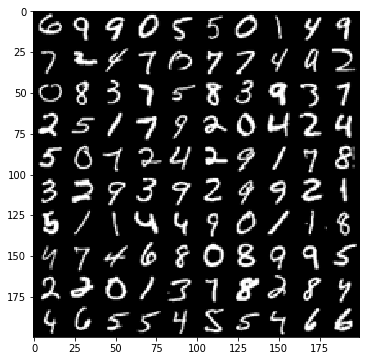

In [8]:
displayData()

### 1.2 模型表示
我们的神经网络如Figure 2所示。它有3层 - 输入层，隐藏层和输出层。 回想一下，我们的输入是数字图像的像素值。 由于图像大小为20×20，因此我们得到400个输入层单元（不包括总是输出+1的额外偏置单元）。 和以前一样，训练数据将被加载到变量X和y中。 
<img src="docimg/fig2.png">
<center>Figure2 神经网络模型</center>
你已经获得了我们已经培训过的一组网络参数(Θ(1),Θ(2))。 它们存储在ex4weights.mat中，并加载到Theta1和Theta2中。参数的大小适合神经网络，第二层有25个单元，10个输出单元（对应10个数字类）。

### 1.3 前向传播与代价函数
现在，你需要为神经网络实现代价函数和梯度函数。  
回想一下，神经网络的代价函数（无正则化）为
$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K\big[-y_k^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(x^{(i)}))_k)\big]
$$